In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import chi2_contingency

from sklearn import preprocessing

pd.options.display.max_rows = 200

In [2]:
# Import cleaned dataset
raw_data = pd.read_csv('../data/Crop_Data__train.csv')

In [3]:
raw_data.shape

(164986, 25)

In [4]:
raw_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,164986,30,UTTAR PRADESH,25759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
District,164986,516,TUMKUR,738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lat,164986,NaN,NaN,NaN,22.1978,5.59709,8.08783,18.5383,23.7214,26.3544,33.2203
Long,164986,NaN,NaN,NaN,80.5854,5.4176,69.611,76.5532,79.3863,83.8242,96.6535
GW_depth_Min,164986,NaN,NaN,NaN,2.9253,3.05719,-0.95,1.4,2.42,3.65,43.95
GW_depth_Max,164986,NaN,NaN,NaN,21.4036,17.2144,-0.21,10.82,17.25,25.68,128.15
Wells_depth_0_to_2,164986,NaN,NaN,NaN,1.27863,2.95843,0,0,0,1,51
Wells_depth_2_to_5,164986,NaN,NaN,NaN,6.93998,8.02365,0,2,4,10,48
Wells_depth_5_to_10,164986,NaN,NaN,NaN,12.1134,11.7355,0,3,9,17,67
Wells_depth_10_to_20,164986,NaN,NaN,NaN,6.7391,8.30502,0,1,4,10,77


In [5]:
numerical_features = raw_data.select_dtypes(exclude='object').columns
categorical_features = raw_data.select_dtypes(include='object').columns

In [6]:
numerical_features

Index(['Lat', 'Long', 'GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed', 'Year', 'Area',
       'Production'],
      dtype='object')

In [7]:
categorical_features

Index(['State', 'District', 'Season', 'Crop'], dtype='object')

In [8]:
# Track dropped columns
cols_to_drop = []

In [9]:
df = raw_data.copy()


## Convert Production values to Log-Normal Form

During EDA we saw that log of 99.5% quantile of Production values had formed a perfect normal distribution.

In [10]:
def convert_to_log(data):
    return np.log(data + 1)

def convert_from_log(data):
    return np.exp(data) - 1

In [11]:
df['log_Production'] = convert_to_log(df['Production'])

/home/animathur/anaconda3/envs/py3-TF2/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_Production', ylabel='Density'>

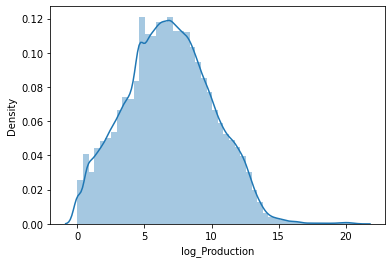

In [12]:
sns.distplot(df['log_Production'])

In [13]:
## Taking data with only 99.5% quantile of log_Production
df = df.loc[df['log_Production'] <= df['log_Production'].quantile(0.995)]

/home/animathur/anaconda3/envs/py3-TF2/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_Production', ylabel='Density'>

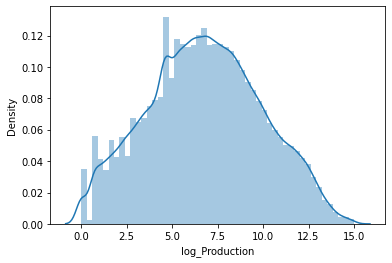

In [14]:
sns.distplot(df['log_Production'])

In [15]:
df.shape

(164161, 26)

In [16]:
# Drop Production column
df.drop('Production', axis=1)

cols_to_drop.append('Production')

## Lat and Long

We must consider Lat and Long as categorical features to avoid any bias in prediction value. This is because numerical values of latitide and longitude do not quantify the production of crop but only provide information of geographical location.

In [17]:
df[['Lat', 'Long']].nunique()

Lat     459
Long    459
dtype: int64

**Pipeline Action**

Based on cluster analysis and EDA we can seggregate Lat and Long values into six regions.

In [18]:
with open('../Analysis_and_Data_Processing/latlong_custerer_6.pkl', 'rb') as f:
    lat_long_clusterer = pickle.load(f)

In [19]:
def identify_geo_region(data, clusterer):
    '''
    Returns dataframe with column 'Geo_Region' identified from values of 'Lat' and 'Long' for each row.
    
    Parameters:
    data - Data frame which should have 'Lat' and 'Long' columns.
    clusterer - Clustering model for Lat and Long.
    '''
    data['Geo_Region'] = clusterer.predict(data[['Lat', 'Long']])
    
    region_map = {}
    
    for i, region in enumerate(df['Geo_Region'].unique()):
        region_map[i] = f'R{i}'
        
    data['Geo_Region'] = data['Geo_Region'].map(region_map).copy()
    
    return data

In [20]:
df = identify_geo_region(df, lat_long_clusterer)

In [21]:
df['Geo_Region'].value_counts().sort_index()

R0    33869
R1    37583
R2    25621
R3    30352
R4    14945
R5    21791
Name: Geo_Region, dtype: int64

In [22]:
df = df.drop(['Lat', 'Long'], axis=1)

In [23]:
cols_to_drop.append('Lat')
cols_to_drop.append('Long')

In [24]:
# Get updated d_types
numerical_features = df.select_dtypes(exclude='object').columns
categorical_features = df.select_dtypes(include='object').columns

# Categorical Variables

In [25]:
categorical_features

Index(['State', 'District', 'Season', 'Crop', 'Geo_Region'], dtype='object')

## State and District

In [26]:
df['State'].nunique()

30

In [27]:
df['District'].nunique()

516

**Pipeline Action**

We can drop State and District columns as they are well represented by Geo_Region clusters.

Also being categorical input with many unique values, State and District would increase the feature set a lot.

In [28]:
df = df.drop(['State', 'District'], axis=1)

cols_to_drop.append('State')
cols_to_drop.append('District')

## Geo_Region

In [29]:
df['Geo_Region'].value_counts()

R1    37583
R0    33869
R3    30352
R2    25621
R5    21791
R4    14945
Name: Geo_Region, dtype: int64

<AxesSubplot:xlabel='Geo_Region', ylabel='log_Production'>

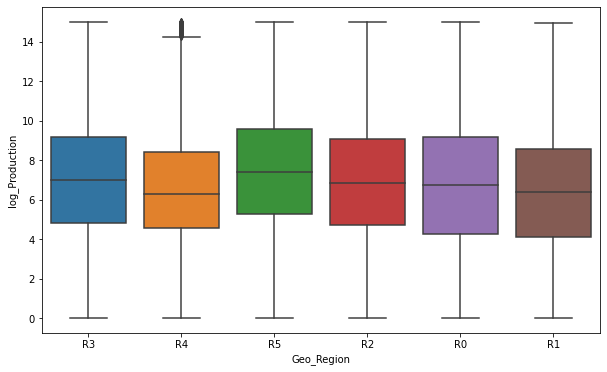

In [30]:
plt.figure(figsize=(10,6))
sns.boxplot(y='log_Production', x='Geo_Region', data=df)

In [31]:
# ANOVA test with log_Production
anova_result = smf.ols(formula='log_Production ~ C(Geo_Region)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     251.3
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          1.90e-268
Time:                        11:53:08   Log-Likelihood:            -4.2062e+05
No. Observations:              164161   AIC:                         8.412e+05
Df Residuals:                  164155   BIC:                         8.413e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.7393      0.017    395.350      0.000       6.706       6.773
C(Geo_Region)[T.R1]    -0.2667      0.024    -11.349      0.000      -0.313      -0.221
C(Geo_Region)[T.R2]     0.1639      0.026      6.312      0.000       0.113       0.215
C(Geo_Region)[T.R3]     0.2259      0.025      9.109      0.000       0.177       0.274
C(Geo_Region)[T.R4]    -0.2875      0.031     -9.332      0.000      -0.348      -0.227
C(Geo_Region)[T.R5]     0.5541      0.027     20.340      0.000       0.501       0.608
==============================================================================
Omnibus:                     4213.695   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2122.652
Skew:                           0.033   Prob(JB):                         0.00
Kurtosis:                       2.447   Cond. No.                         6.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Season

In [32]:
df['Season'].value_counts()

Kharif        63256
Rabi          44259
Whole Year    38389
Summer        10731
Winter         4180
Autumn         3346
Name: Season, dtype: int64

<AxesSubplot:xlabel='Season', ylabel='log_Production'>

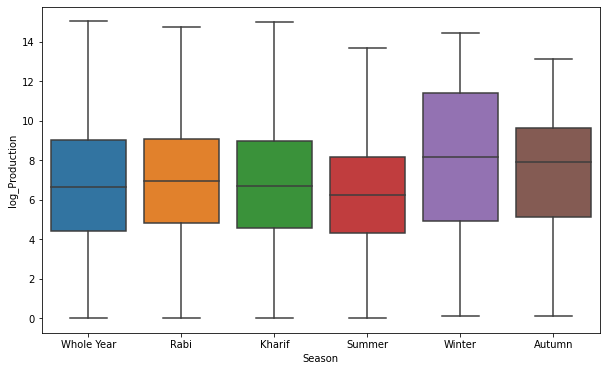

In [33]:
plt.figure(figsize=(10,6))
sns.boxplot(y='log_Production', x='Season', data=df)

In [34]:
# ANOVA test with log_Production
anova_result = smf.ols(formula='log_Production ~ C(Season)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     224.7
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          7.76e-240
Time:                        11:53:09   Log-Likelihood:            -4.2068e+05
No. Observations:              164161   AIC:                         8.414e+05
Df Residuals:                  164155   BIC:                         8.414e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   7.2056      0.054    132.808      0.000       7.099       7.312
C(Season)[T.Kharif]        -0.4804      0.056     -8.630      0.000      -0.590      -0.371
C(Season)[T.Rabi]          -0.2439      0.056     -4.335      0.000      -0.354      -0.134
C(Season)[T.Summer]        -1.0093      0.062    -16.242      0.000      -1.131      -0.887
C(Season)[T.Whole Year]    -0.4830      0.057     -8.538      0.000      -0.594      -0.372
C(Season)[T.Winter]         0.6739      0.073      9.256      0.000       0.531       0.817
==============================================================================
Omnibus:                     4694.481   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2271.511
Skew:                           0.020   Prob(JB):                         0.00
Kurtosis:                       2.425   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Crop

In [35]:
df['Crop'].nunique()

86

In [36]:
# ANOVA test with log_Production
anova_result = smf.ols(formula='log_Production ~ C(Crop)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     881.0
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:53:14   Log-Likelihood:            -3.9038e+05
No. Observations:              164161   AIC:                         7.809e+05
Df Residuals:                  164075   BIC:                         7.818e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                7.4944      0.674     11.121      0.000       6.174       8.815
C(Crop)[T.Arecanut]                     -0.3931      0.678     -0.580      0.562      -1.723       0.936
C(Crop)[T.Arhar/Tur]                    -0.7483      0.675     -1.109      0.267      -2.071       0.574
C(Crop)[T.Atcanut (Raw)]                 1.3429      0.925      1.452      0.146      -0.469       3.155
C(Crop)[T.Bajra]                        -0.2497      0.675     -0.370      0.712      -1.573       1.074
C(Crop)[T.Banana]                        1.5601      0.676      2.307      0.021       0.235       2.885
C(Crop)[T.Barley]                       -0.5509      0.676     -0.815      0.415      -1.875       0.773
C(Crop)[T.Beans & Mutter(Vegetable)]    -3.8055      0.717     -5.308      0.000      -5.211      -2.400
C(Crop)[T.Bhindi]                       -4.2028      0.701     -5.993      0.000      -5.577      -2.828
C(Crop)[T.Black pepper]                 -2.0104      0.681     -2.951      0.003      -3.345      -0.675
C(Crop)[T.Blackgram]                    -1.7874      0.770     -2.321      0.020      -3.297      -0.278
C(Crop)[T.Brinjal]                      -2.2204      0.692     -3.207      0.001      -3.578      -0.863
C(Crop)[T.Cabbage]                      -4.6142      0.708     -6.516      0.000      -6.002      -3.226
C(Crop)[T.Cardamom]                     -3.5614      0.692     -5.145      0.000      -4.918      -2.205
C(Crop)[T.Cashewnut]                    -1.8109      0.680     -2.663      0.008      -3.144      -0.478
C(Crop)[T.Cashewnut Processed]          -4.8331      0.902     -5.361      0.000      -6.600      -3.066
C(Crop)[T.Cashewnut Raw]                -1.7246      0.825     -2.089      0.037      -3.342      -0.107
C(Crop)[T.Castor seed]                  -2.9953      0.676     -4.431      0.000      -4.320      -1.670
C(Crop)[T.Citrus Fruit]                 -3.9450      0.696     -5.672      0.000      -5.308      -2.582
C(Crop)[T.Coconut ]                      2.7328      0.679      4.022      0.000       1.401       4.064
C(Crop)[T.Coffee]                        1.6898      1.469      1.150      0.250      -1.189       4.569
C(Crop)[T.Colocosia]                     0.2379      2.696      0.088      0.930      -5.046       5.521
C(Crop)[T.Coriander]                    -3.5623      0.676     -5.270      0.000      -4.887      -2.237
C(Crop)[T.Cotton(lint)]                  0.1660      0.675      0.246      0.806      -1.158       1.490
C(Crop)[T.Cowpea(Lobia)]                -3.1934      0.687     -4.647      0.000      -4.540      -1.847
C(Crop)[T.Drum Stick]                   -4.0833      0.725     -5.631      0.000      -5.505      -2.662
C(Crop)[T.Dry chillies]               

In [37]:
# Chi2 test
chi2_contingency(pd.crosstab(df['Crop'], df['Season']))

(227650.14111136392,
 0.0,
 425,
 array([[3.05736442e-01, 5.77993555e+00, 4.04410914e+00, 9.80531308e-01,
         3.50774545e+00, 3.81942118e-01],
        [2.29913804e+01, 4.34651153e+02, 3.04117007e+02, 7.37359543e+01,
         2.63782457e+02, 2.87220473e+01],
        [1.10167031e+02, 2.08270344e+03, 1.45722733e+03, 3.53318115e+02,
         1.26395761e+03, 1.37626476e+02],
        [3.46501301e-01, 6.55059362e+00, 4.58332369e+00, 1.11126882e+00,
         3.97544484e+00, 4.32867734e-01],
        [8.25896041e+01, 1.56135326e+03, 1.09244868e+03, 2.64874191e+02,
         9.47558970e+02, 1.03175297e+02],
        [4.61865851e+01, 8.73155597e+02, 6.10930087e+02, 1.48125596e+02,
         5.29903412e+02, 5.76987226e+01],
        [5.90275157e+01, 1.11591289e+03, 7.80782671e+02, 1.89307911e+02,
         6.77228721e+02, 7.37402915e+01],
        [2.32359696e+00, 4.39275102e+01, 3.07352294e+01, 7.45203794e+00,
         2.66588654e+01, 2.90276010e+00],
        [3.68921973e+00, 6.97445556e+01, 4.8798

Ideally crops are very much dependent on season. p-value of chi2 test validates this.

**Pipeline Action**

As per custer analysis and EDA, we can reduce the feature set by clustering both Season and Crop columns as Crop_Type.

In [38]:
with open('../Analysis_and_Data_Processing/crop_season_clusterer_6.pkl', 'rb') as f:
    crop_season_clusterer = pickle.load(f)

In [39]:
def identify_crop_types(data, clusterer):
    '''
    Returns dataframe with column 'Crop_Type' identified from values of 'Crop' and 'Season' for each row.
    
    Parameters:
    data - Dataframe which should have 'Crop' and 'Season' columns.
    clusterer - Clustering model for Crop and Season.
    '''
    data['Crop_Type'] = clusterer.predict(pd.get_dummies(data[['Crop', 'Season']].copy()))
    
    crop_type_map = {}
    
    for i, crop_type in enumerate(data['Crop_Type'].unique()):
        crop_type_map[i] = f'C{i}'
        
    data['Crop_Type'] = data['Crop_Type'].map(crop_type_map).copy()
    return data

In [40]:
df = identify_crop_types(df, crop_season_clusterer)

In [41]:
df['Crop_Type'].value_counts().sort_index()

C0     7525
C1    36329
C2    44259
C3    63256
C4     2061
C5    10731
Name: Crop_Type, dtype: int64

In [42]:
# ANOVA test with log_Production
anova_result = smf.ols(formula='log_Production ~ C(Crop_Type)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     523.2
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:53:16   Log-Likelihood:            -4.1995e+05
No. Observations:              164161   AIC:                         8.399e+05
Df Residuals:                  164155   BIC:                         8.400e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.5807      0.036    210.477      0.000       7.510       7.651
C(Crop_Type)[T.C1]    -0.7078      0.040    -17.886      0.000      -0.785      -0.630
C(Crop_Type)[T.C2]    -0.6190      0.039    -15.889      0.000      -0.695      -0.543
C(Crop_Type)[T.C3]    -0.8555      0.038    -22.455      0.000      -0.930      -0.781
C(Crop_Type)[T.C4]    -3.5092      0.078    -45.177      0.000      -3.661      -3.357
C(Crop_Type)[T.C5]    -1.3844      0.047    -29.469      0.000      -1.476      -1.292
==============================================================================
Omnibus:                     4144.411   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2080.424
Skew:                           0.010   Prob(JB):                         0.00
Kurtosis:                       2.449   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Note**

Looks like there is significant change in Adj. R-squared when we use cluster of crops and seasons.

For now we will continue using Crop_Type assuming that it can represent Crop and Season.

**To Do** 

Try forward selection for Crop, Season and Crop_Type seperately to validate the assumption in the end.

# Numerical Features

In [43]:
numerical_features

Index(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed', 'Year', 'Area',
       'Production', 'log_Production'],
      dtype='object')

**Pipeline Action**

Drop 'Year'column to avoid time-series factor.

In [44]:
# Drop Year column
df = df.drop('Year', axis=1)

cols_to_drop.append('Year')

In [45]:
# Get updated d_types
numerical_features = df.select_dtypes(exclude='object').columns
categorical_features = df.select_dtypes(include='object').columns

## Area

As per EDA, we saw that log Area had linear relationship with log_Production.

**Pipeline Action**

1. Create column log_Area as log of column Area.
2. Drop column Area.

In [46]:
df['log_Area'] = np.log(df['Area'] + 1)
df = df.drop('Area', axis=1)

cols_to_drop.append('Area')

<AxesSubplot:xlabel='log_Area', ylabel='log_Production'>

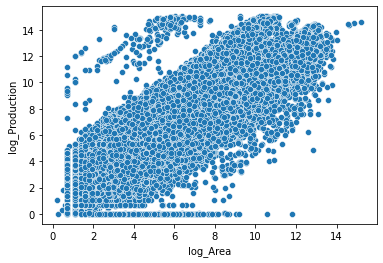

In [47]:
sns.scatterplot(x='log_Area', y='log_Production', data=df)

Hence, log_Area turns out to be an important feature. We will use it as first feature ro do forward selection.

In [48]:
smf.ols(formula='log_Production ~ log_Area', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                 6.289e+05
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:53:16   Log-Likelihood:            -2.9196e+05
No. Observations:              164161   AIC:                         5.839e+05
Df Residuals:                  164159   BIC:                         5.839e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2537      0.009     28.274      0.000       0.236       0.271
log_Area       1.0019      0.001    793.043      0.000       0.999       1.004
==============================================================================
Omnibus:                    22433.495   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74212.520
Skew:                           0.697   Prob(JB):                         0.00
Kurtosis:                       5.984   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# Get updated d_types
numerical_features = df.select_dtypes(exclude='object').columns
categorical_features = df.select_dtypes(include='object').columns

## Check for multicollinearity

In [50]:
# DF for all numerical columns
X_numerical = df[numerical_features].drop(['Production', 'log_Production'], axis=1)
X_numerical.columns

Index(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed', 'log_Area'],
      dtype='object')

In [51]:
X_numerical.shape

(164161, 17)

In [52]:
X_numerical = pd.DataFrame(preprocessing.scale(X_numerical), columns=X_numerical.columns)

In [53]:
def test_vif(data):
    vif_data = pd.DataFrame()
    vif_data['feature'] = data.columns
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

In [54]:
# VIF with all numerical columns
test_vif(X_numerical)

,feature,VIF
0,GW_depth_Min,1.266103
1,GW_depth_Max,2.739832
2,Wells_depth_0_to_2,1.867364
3,Wells_depth_2_to_5,2.715129
4,Wells_depth_5_to_10,2.211923
5,Wells_depth_10_to_20,2.134399
6,Wells_depth_20_to_40,2.546609
7,Wells_depth_40_and_above,1.789100
8,Precipitation,4.599284
9,Solar_Radiation,2.611799


### Only among features related to water resource

<AxesSubplot:>

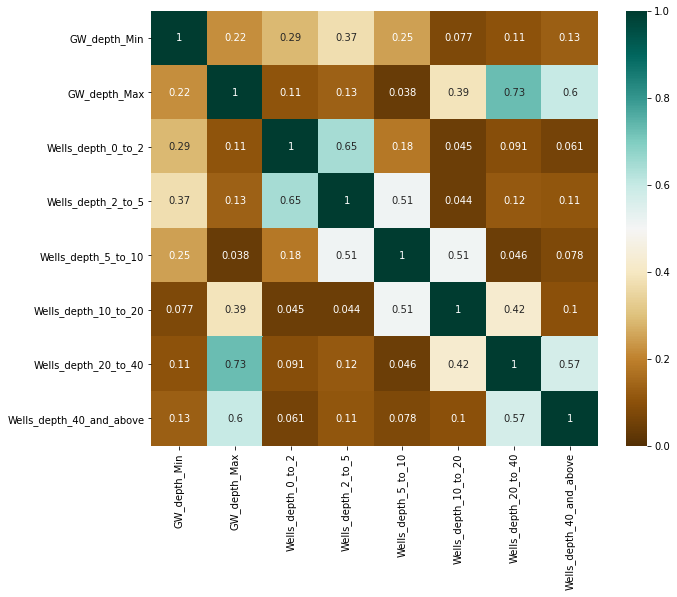

In [55]:
X_water = X_numerical[['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above']]
plt.figure(figsize=(10, 8))
sns.heatmap(X_water.corr().abs(), annot=True, cmap=plt.cm.BrBG, vmin=0, vmax=1)

In [56]:
# VIF with features related to only water resources
test_vif(X_water)

,feature,VIF
0,GW_depth_Min,1.247283
1,GW_depth_Max,2.616519
2,Wells_depth_0_to_2,1.824669
3,Wells_depth_2_to_5,2.613844
4,Wells_depth_5_to_10,2.147148
5,Wells_depth_10_to_20,1.969633
6,Wells_depth_20_to_40,2.504294
7,Wells_depth_40_and_above,1.773421


**Note**

All water resources columns seems to have no multi-collinearity.

In [57]:
def ols_summary(cols, data):
    formula_str = "log_Production ~ "
    for col in cols:
        formula_str += f" + {col}"
    return smf.ols(formula=formula_str, data=df).fit().summary()

### Only among features related to climate

<AxesSubplot:>

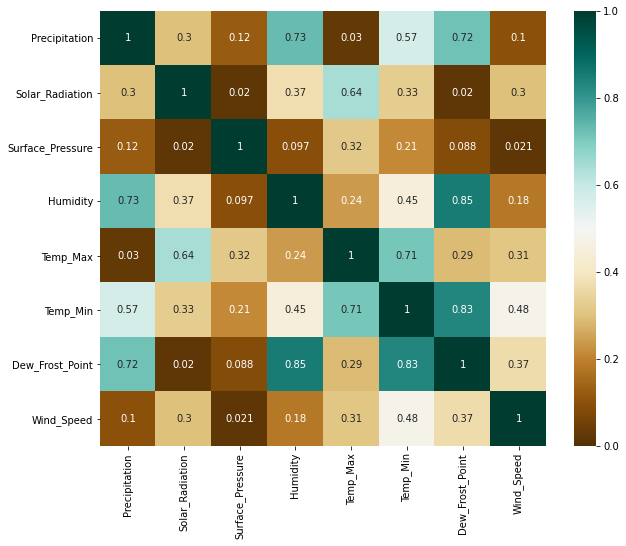

In [58]:
X_climate = X_numerical[['Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']]

plt.figure(figsize=(10, 8))
sns.heatmap(X_climate.corr().abs(), annot=True, cmap=plt.cm.BrBG, vmin=0, vmax=1)

In [59]:
# VIF with features related to only climate
test_vif(X_climate)

,feature,VIF
0,Precipitation,4.472036
1,Solar_Radiation,2.475327
2,Surface_Pressure,1.367474
3,Humidity,83.784717
4,Temp_Max,18.911486
5,Temp_Min,30.217529
6,Dew_Frost_Point,115.536944
7,Wind_Speed,1.569294


**Note**

Taking correlation cut-off as 80.

We find following as highly correlated features:
1. Humidity vs. Dew_Frost_Point
2. Temp_Min vs Dew_Frost_Point

**Pipeline Action**

Drop column Dew_Frost_Point due to high correlation (above 80)

In [60]:
# Dropping column Dew_Frost_Point
X_climate = X_climate.drop('Dew_Frost_Point', axis=1)
X_numerical = X_numerical.drop('Dew_Frost_Point', axis=1)
df = df.drop('Dew_Frost_Point', axis=1)

cols_to_drop.append('Dew_Frost_Point')

<AxesSubplot:>

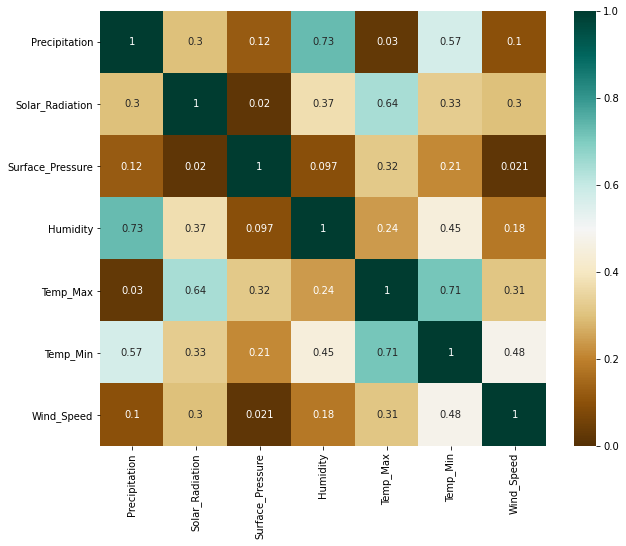

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_climate.corr().abs(), annot=True, cmap=plt.cm.BrBG, vmin=0, vmax=1)

In [62]:
# VIF of climate features after removing Dew_Frost_Point
test_vif(X_climate)

,feature,VIF
0,Precipitation,3.773542
1,Solar_Radiation,2.472454
2,Surface_Pressure,1.361832
3,Humidity,6.616351
4,Temp_Max,11.722162
5,Temp_Min,17.031071
6,Wind_Speed,1.561266


In [63]:
test_vif(X_climate.drop('Temp_Min', axis=1))

,feature,VIF
0,Precipitation,2.951358
1,Solar_Radiation,2.402864
2,Surface_Pressure,1.320890
3,Humidity,2.915329
4,Temp_Max,2.813404
5,Wind_Speed,1.297970


## Correlation among all numeric features

<AxesSubplot:>

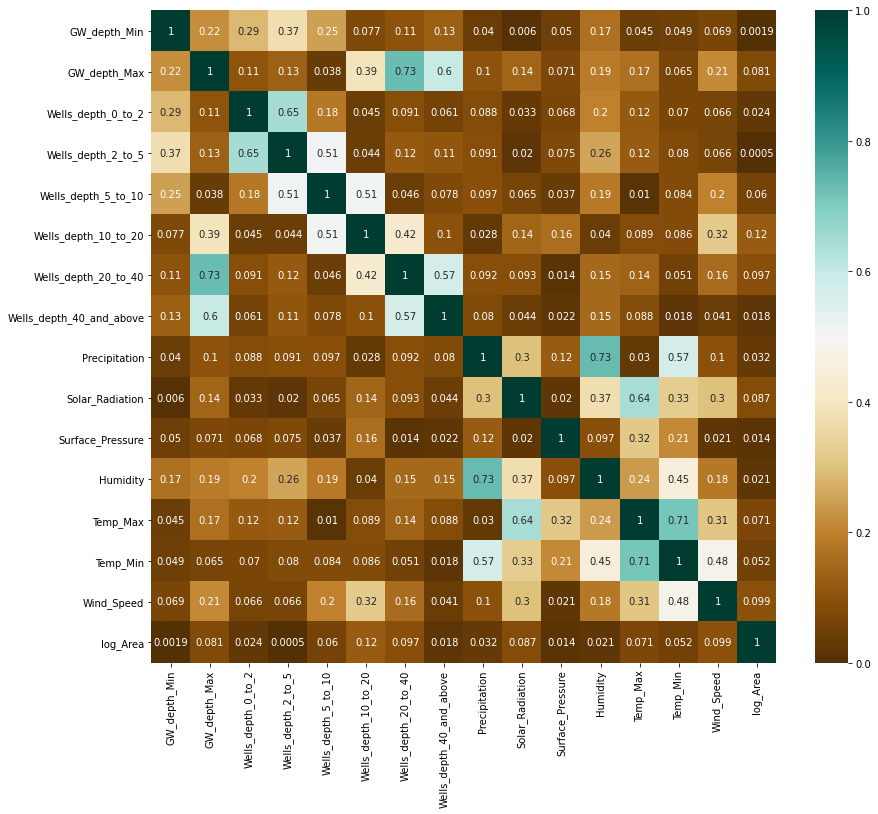

In [64]:
plt.figure(figsize=(14, 12))
sns.heatmap(X_numerical.corr().abs(), annot=True, cmap=plt.cm.BrBG, vmin=0, vmax=1)

In [65]:
df.shape

(164161, 22)

In [66]:
X_numerical.shape

(164161, 16)

In [67]:
df_scaled = df.drop(X_numerical.columns, axis=1).reset_index(drop=True)
df_scaled = pd.concat([X_numerical.reset_index(drop=True), df_scaled], axis=1)
df_scaled.head()

,GW_depth_Min,GW_depth_Max,Wells_depth_0_to_2,Wells_depth_2_to_5,Wells_depth_5_to_10,Wells_depth_10_to_20,Wells_depth_20_to_40,Wells_depth_40_and_above,Precipitation,Solar_Radiation,...,Temp_Max,Temp_Min,Wind_Speed,log_Area,Season,Crop,Production,log_Production,Geo_Region,Crop_Type
0,0.236061,-0.064555,-0.432794,-0.364849,-0.435097,-0.087678,-0.134633,-0.170215,-0.379932,0.796416,...,0.075480,-0.007716,1.293971,-0.779955,Whole Year,Coriander,26.0,3.295837,R3,C4
1,-0.323045,-0.825789,0.248394,-0.740607,-0.948571,-0.812963,-0.468518,-0.170215,-0.906771,-0.223762,...,-1.723121,-1.460980,-1.895846,-0.191286,Rabi,Urad,222.0,5.407172,R4,C2
2,0.039883,0.957393,-0.432794,-0.364849,0.420693,0.395845,1.200908,-0.170215,1.510865,-0.220965,...,0.172730,0.846688,0.964550,1.055243,Kharif,Urad,10700.0,9.278092,R5,C3
3,-0.159564,-0.047135,-0.432794,-0.364849,-0.520676,0.033202,-0.134633,-0.170215,-0.243467,0.117955,...,0.662152,0.002897,0.190874,0.346085,Whole Year,Guar seed,45.0,3.828641,R5,C1
4,-0.911577,-0.958759,-0.092200,-0.239596,-0.862992,-0.812963,-0.468518,-0.170215,-0.049701,-1.032242,...,-0.224199,-0.199580,-2.160311,0.478288,Whole Year,Potato,16774.0,9.727645,R4,C1


In [68]:
df_scaled.shape

(164161, 22)

In [69]:
# OLS on only numerical features
smf.ols(formula='log_Production ~ GW_depth_Min + GW_depth_Max + Wells_depth_0_to_2 + Wells_depth_2_to_5 + Wells_depth_5_to_10 + Wells_depth_10_to_20 + Wells_depth_20_to_40 + Wells_depth_40_and_above + Precipitation + Solar_Radiation + Surface_Pressure + Humidity + Temp_Max + Temp_Min + Wind_Speed + log_Area', data=df_scaled).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 4.040e+04
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:53:30   Log-Likelihood:            -2.9016e+05
No. Observations:              164161   AIC:                         5.804e+05
Df Residuals:                  164144   BIC:                         5.805e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    6.7929      0.003   1942.142      0.000       6.786       6.800
GW_depth_Min                 0.0132      0.004      3.346      0.001       0.005       0.021
GW_depth_Max                -0.0146      0.006     -2.519      0.012      -0.026      -0.003
Wells_depth_0_to_2          -0.0270      0.005     -5.657      0.000      -0.036      -0.018
Wells_depth_2_to_5           0.0572      0.006      9.920      0.000       0.046       0.068
Wells_depth_5_to_10         -0.1177      0.005    -22.652      0.000      -0.128      -0.108
Wells_depth_10_to_20         0.0322      0.005      6.295      0.000       0.022       0.042
Wells_depth_20_to_40         0.0007      0.006      0.123      0.902      -0.010       0.012
Wells_depth_40_and_above    -0.0416      0.005     -8.901      0.000      -0.051      -0.032
Precipitation                0.0845      0.007     12.203      0.000       0.071       0.098
Solar_Radiation              0.2184      0.006     38.634      0.000       0.207       0.229
Surface_Pressure             0.1518      0.004     36.043      0.000       0.144       0.160
Humidity                    -0.1189      0.010    -12.443      0.000      -0.138      -0.100
Temp_Max                    -0.2797      0.013    -22.021      0.000      -0.305      -0.255
Temp_Min                     0.1040      0.015      6.749      0.000       0.074       0.134
Wind_Speed                  -0.0521      0.005    -11.037      0.000      -0.061      -0.043
log_Area                     2.8215      0.004    786.556      0.000       2.814       2.829
==============================================================================
Omnibus:                    23246.785   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78692.038
Skew:                           0.715   Prob(JB):                         0.00
Kurtosis:                       6.075   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# OLS using Crop_Type (with Temp_Min)
smf.ols(formula='log_Production ~ GW_depth_Min + GW_depth_Max + Wells_depth_0_to_2 + Wells_depth_2_to_5 + Wells_depth_5_to_10 + Wells_depth_10_to_20 + Wells_depth_20_to_40 + Wells_depth_40_and_above + Precipitation + Solar_Radiation + Surface_Pressure + Humidity + Temp_Max + Temp_Min + Wind_Speed + C(Geo_Region) + C(Crop_Type) + log_Area', data=df_scaled).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                 3.045e+04
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:53:31   Log-Likelihood:            -2.7663e+05
No. Observations:              164161   AIC:                         5.533e+05
Df Residuals:                  164134   BIC:                         5.536e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    6.6049      0.022    296.951      0.000       6.561       6.649
C(Geo_Region)[T.R1]         -0.1340      0.012    -11.121      0.000      -0.158      -0.110
C(Geo_Region)[T.R2]         -0.2836      0.014    -19.571      0.000      -0.312      -0.255
C(Geo_Region)[T.R3]         -0.1494      0.017     -8.940      0.000      -0.182      -0.117
C(Geo_Region)[T.R4]         -0.1800      0.018     -9.872      0.000      -0.216      -0.144
C(Geo_Region)[T.R5]         -0.3962      0.015    -26.972      0.000      -0.425      -0.367
C(Crop_Type)[T.C1]           1.3965      0.021     65.742      0.000       1.355       1.438
C(Crop_Type)[T.C2]           0.0471      0.019      2.524      0.012       0.011       0.084
C(Crop_Type)[T.C3]           0.0011      0.026      0.043      0.966      -0.049       0.051
C(Crop_Type)[T.C4]          -0.5922      0.035    -16.739      0.000      -0.661      -0.523
C(Crop_Type)[T.C5]           0.6856      0.030     22.941      0.000       0.627       0.744
GW_depth_Min                 0.0094      0.004      2.573      0.010       0.002       0.017
GW_depth_Max                -0.0222      0.006     -4.010      0.000      -0.033      -0.011
Wells_depth_0_to_2          -0.0445      0.005     -9.805      0.000      -0.053      -0.036
Wells_depth_2_to_5           0.0537      0.005      9.904      0.000       0.043       0.064
Wells_depth_5_to_10         -0.1310      0.005    -26.101      0.000      -0.141      -0.121
Wells_depth_10_to_20         0.0351      0.005      7.213      0.000       0.026       0.045
Wells_depth_20_to_40         0.0438      0.005      8.305      0.000       0.033       0.054
Wells_depth_40_and_above    -0.0598      0.004    -13.703      0.000      -0.068      -0.051
Precipitation                0.0833      0.007     11.480      0.000       0.069       0.098
Solar_Radiation              0.0502      0.006      8.142      0.000       0.038       0.062
Surface_Pressure             0.1533      0.005     30.183      0.000       0.143       0.163
Humidity                     0.0228      0.011      2.120      0.034       0.002       0.044
Temp_Max                    -0.1248      0.013     -9.840      0.000      -0.150      -0.100
Temp_Min                    -0.0738      0.016     -4.560      0.000      -0.106      -0.042
Wind_Speed                   0.0134      0.007      2.057      0.040       0.001       0.026
log_Area                     2.9113      0.003    862.161      0.000       2.905       2.918
==============================================================================
Omnibus:                    15540.571   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           113067.940
Skew:                           0.115   Prob(JB):       

In [71]:
# OLS using Crop_Type (without Temp_Min)
smf.ols(formula='log_Production ~ GW_depth_Min + GW_depth_Max + Wells_depth_0_to_2 + Wells_depth_2_to_5 + Wells_depth_5_to_10 + Wells_depth_10_to_20 + Wells_depth_20_to_40 + Wells_depth_40_and_above + Precipitation + Solar_Radiation + Surface_Pressure + Humidity + Temp_Max + Wind_Speed + C(Geo_Region) + C(Crop_Type) + log_Area', data=df_scaled).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                 3.166e+04
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:53:33   Log-Likelihood:            -2.7664e+05
No. Observations:              164161   AIC:                         5.533e+05
Df Residuals:                  164135   BIC:                         5.536e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    6.6046      0.022    296.920      0.000       6.561       6.648
C(Geo_Region)[T.R1]         -0.1238      0.012    -10.456      0.000      -0.147      -0.101
C(Geo_Region)[T.R2]         -0.2717      0.014    -19.060      0.000      -0.300      -0.244
C(Geo_Region)[T.R3]         -0.1325      0.016     -8.131      0.000      -0.164      -0.101
C(Geo_Region)[T.R4]         -0.1792      0.018     -9.827      0.000      -0.215      -0.143
C(Geo_Region)[T.R5]         -0.3794      0.014    -26.678      0.000      -0.407      -0.352
C(Crop_Type)[T.C1]           1.3855      0.021     65.643      0.000       1.344       1.427
C(Crop_Type)[T.C2]           0.0559      0.019      3.006      0.003       0.019       0.092
C(Crop_Type)[T.C3]          -0.0212      0.025     -0.842      0.400      -0.071       0.028
C(Crop_Type)[T.C4]          -0.6006      0.035    -17.000      0.000      -0.670      -0.531
C(Crop_Type)[T.C5]           0.6777      0.030     22.713      0.000       0.619       0.736
GW_depth_Min                 0.0090      0.004      2.454      0.014       0.002       0.016
GW_depth_Max                -0.0228      0.006     -4.135      0.000      -0.034      -0.012
Wells_depth_0_to_2          -0.0459      0.005    -10.140      0.000      -0.055      -0.037
Wells_depth_2_to_5           0.0502      0.005      9.352      0.000       0.040       0.061
Wells_depth_5_to_10         -0.1295      0.005    -25.862      0.000      -0.139      -0.120
Wells_depth_10_to_20         0.0356      0.005      7.314      0.000       0.026       0.045
Wells_depth_20_to_40         0.0434      0.005      8.238      0.000       0.033       0.054
Wells_depth_40_and_above    -0.0609      0.004    -13.968      0.000      -0.069      -0.052
Precipitation                0.0725      0.007     10.570      0.000       0.059       0.086
Solar_Radiation              0.0419      0.006      7.118      0.000       0.030       0.053
Surface_Pressure             0.1467      0.005     30.131      0.000       0.137       0.156
Humidity                    -0.0088      0.008     -1.076      0.282      -0.025       0.007
Temp_Max                    -0.1701      0.008    -21.552      0.000      -0.186      -0.155
Wind_Speed                   0.0029      0.006      0.481      0.630      -0.009       0.015
log_Area                     2.9118      0.003    862.637      0.000       2.905       2.918
==============================================================================
Omnibus:                    15565.373   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           113503.093
Skew:                           0.115   Prob(JB):                         0.00
Kurtosis:                       7.067   Cond. No.                     

In [72]:
smf.ols(formula='log_Production ~ C(Crop_Type) + log_Area', data=df_scaled).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                 1.275e+05
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:53:33   Log-Likelihood:            -2.7894e+05
No. Observations:              164161   AIC:                         5.579e+05
Df Residuals:                  164154   BIC:                         5.580e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.5866      0.015    430.503      0.000       6.557       6.617
C(Crop_Type)[T.C1]     1.2030      0.017     71.153      0.000       1.170       1.236
C(Crop_Type)[T.C2]    -0.0032      0.017     -0.193      0.847      -0.036       0.029
C(Crop_Type)[T.C3]    -0.1883      0.016    -11.652      0.000      -0.220      -0.157
C(Crop_Type)[T.C4]    -0.8621      0.033    -26.090      0.000      -0.927      -0.797
C(Crop_Type)[T.C5]     0.3721      0.020     18.604      0.000       0.333       0.411
log_Area               2.8970      0.003    866.409      0.000       2.890       2.904
==============================================================================
Omnibus:                    15411.084   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111728.679
Skew:                           0.106   Prob(JB):                         0.00
Kurtosis:                       7.036   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# OLS using Crop + Season (without Temp_Min)
smf.ols(formula='log_Production ~ GW_depth_Min + GW_depth_Max + Wells_depth_0_to_2 + Wells_depth_2_to_5 + Wells_depth_5_to_10 + Wells_depth_10_to_20 + Wells_depth_20_to_40 + Wells_depth_40_and_above + Precipitation + Solar_Radiation + Surface_Pressure + Humidity + Temp_Max + Wind_Speed + C(Geo_Region) + C(Crop) + C(Season) + log_Area', data=df_scaled).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Production   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 2.237e+04
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:53:41   Log-Likelihood:            -1.9367e+05
No. Observations:              164161   AIC:                         3.876e+05
Df Residuals:                  164050   BIC:                         3.887e+05
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                6.5474      0.204     32.076      0.000       6.147       6.947
C(Geo_Region)[T.R1]                     -0.0825      0.007    -11.394      0.000      -0.097      -0.068
C(Geo_Region)[T.R2]                     -0.1171      0.009    -13.185      0.000      -0.135      -0.100
C(Geo_Region)[T.R3]                      0.1355      0.010     13.172      0.000       0.115       0.156
C(Geo_Region)[T.R4]                     -0.3300      0.011    -29.395      0.000      -0.352      -0.308
C(Geo_Region)[T.R5]                     -0.1206      0.009    -13.682      0.000      -0.138      -0.103
C(Crop)[T.Arecanut]                     -0.0664      0.205     -0.324      0.746      -0.468       0.335
C(Crop)[T.Arhar/Tur]                    -0.7330      0.204     -3.596      0.000      -1.133      -0.334
C(Crop)[T.Atcanut (Raw)]                 1.5352      0.279      5.502      0.000       0.988       2.082
C(Crop)[T.Bajra]                        -0.4086      0.204     -2.003      0.045      -0.808      -0.009
C(Crop)[T.Banana]                        2.6976      0.204     13.218      0.000       2.298       3.098
C(Crop)[T.Barley]                       -0.1518      0.204     -0.743      0.457      -0.552       0.248
C(Crop)[T.Beans & Mutter(Vegetable)]    -1.1729      0.216     -5.421      0.000      -1.597      -0.749
C(Crop)[T.Bhindi]                       -1.8279      0.212     -8.636      0.000      -2.243      -1.413
C(Crop)[T.Black pepper]                 -0.7618      0.206     -3.705      0.000      -1.165      -0.359
C(Crop)[T.Blackgram]                    -0.8101      0.233     -3.483      0.000      -1.266      -0.354
C(Crop)[T.Brinjal]                      -0.4524      0.209     -2.165      0.030      -0.862      -0.043
C(Crop)[T.Cabbage]                      -1.1737      0.214     -5.490      0.000      -1.593      -0.755
C(Crop)[T.Cardamom]                     -2.9056      0.209    -13.904      0.000      -3.315      -2.496
C(Crop)[T.Cashewnut]                    -1.2586      0.205     -6.131      0.000      -1.661      -0.856
C(Crop)[T.Cashewnut Processed]          -2.2525      0.272     -8.280      0.000      -2.786      -1.719
C(Crop)[T.Cashewnut Raw]                -1.1221      0.249     -4.505      0.000      -1.610      -0.634
C(Crop)[T.Castor seed]                  -0.8995      0.204     -4.406      0.000      -1.300      -0.499
C(Crop)[T.Citrus Fruit]                 -0.8920      0.210     -4.249      0.000      -1.303      -0.481
C(Crop)[T.Coconut ]                      2.8515      0.205     13.907      0.000       2.450       3.253
C(Crop)[T.Coffee]                       -0.8216      0.443     -1.853      0.064      -1.690       0.047
C(Crop)[T.Colocosia]                  

**Observations**

1. We see there is no direct high correation anymore among features based on correlation matrix.
2. VIF values are very high for features related to climate, due to high multi-collinearity of Temp_Min column.
3. Removing Temp_Min column did not reduce Adj. R-squared using OLS. Hence, it may not be good feature for linear models.
3. 'Crop + Season' columns instead of 'Crop_Type' column provides significantly high Adj. R-squared using OLS.

Based upon EDA and analysis during Feature Engineering we saw that features except log-Area do not show linear relationship with log-Production (target).

**Notes**

1. Lets ignore any multicollinearity / VIF for now, assuming that there may be non-linear relationship between features and target.

2. Try retaining the column 'Crop_Type' for reduced dimensionality and use it for checking importance w.r.t. 'Crop + Season' when using non-linear models.

**Next step**

Check importance of features based on various non-linear models.

# Feature importance

In [74]:
# X with Crop_Type
X_for_Crop_Type = df_scaled.drop(['Crop', 'Season', 'Production', 'log_Production'], axis=1).reset_index(drop=True)

# X with Crop and Season
X_for_Crop = df_scaled.drop(['Crop_Type', 'Production', 'log_Production'], axis=1).reset_index(drop=True)

# Target y as log_Production
y = df_scaled['log_Production'].reset_index(drop=True).copy()

## Using Decision Tree Regressor

In [75]:
from sklearn.tree import DecisionTreeRegressor

In [76]:
from sklearn.model_selection import train_test_split

### Using Crop_Type

In [77]:
X_for_Crop_Type.head()

,GW_depth_Min,GW_depth_Max,Wells_depth_0_to_2,Wells_depth_2_to_5,Wells_depth_5_to_10,Wells_depth_10_to_20,Wells_depth_20_to_40,Wells_depth_40_and_above,Precipitation,Solar_Radiation,Surface_Pressure,Humidity,Temp_Max,Temp_Min,Wind_Speed,log_Area,Geo_Region,Crop_Type
0,0.236061,-0.064555,-0.432794,-0.364849,-0.435097,-0.087678,-0.134633,-0.170215,-0.379932,0.796416,-0.984798,0.116285,0.075480,-0.007716,1.293971,-0.779955,R3,C4
1,-0.323045,-0.825789,0.248394,-0.740607,-0.948571,-0.812963,-0.468518,-0.170215,-0.906771,-0.223762,0.041439,-0.034345,-1.723121,-1.460980,-1.895846,-0.191286,R4,C2
2,0.039883,0.957393,-0.432794,-0.364849,0.420693,0.395845,1.200908,-0.170215,1.510865,-0.220965,0.781147,1.141509,0.172730,0.846688,0.964550,1.055243,R5,C3
3,-0.159564,-0.047135,-0.432794,-0.364849,-0.520676,0.033202,-0.134633,-0.170215,-0.243467,0.117955,0.130572,-0.710431,0.662152,0.002897,0.190874,0.346085,R5,C1
4,-0.911577,-0.958759,-0.092200,-0.239596,-0.862992,-0.812963,-0.468518,-0.170215,-0.049701,-1.032242,-0.196287,0.116586,-0.224199,-0.199580,-2.160311,0.478288,R4,C1


In [78]:
X_input = X_for_Crop_Type.iloc[:,:-2].copy()
X_input = pd.concat([X_input, pd.get_dummies(X_for_Crop_Type.iloc[:,-2:])], axis=1)
X_input.shape

(164161, 28)

In [79]:
reg = DecisionTreeRegressor()

reg.fit(X_input, y)

reg.score(X_input, y)

0.998107430588427

In [80]:
# reg.feature_importances_
scores = pd.DataFrame(X_input.columns, columns=['Feature'])
scores['Score'] = reg.feature_importances_

scores.sort_values(by='Score', ascending=False)

,Feature,Score
15,log_Area,0.825504
23,Crop_Type_C1,0.028961
10,Surface_Pressure,0.018883
14,Wind_Speed,0.015242
11,Humidity,0.012503
13,Temp_Min,0.012097
12,Temp_Max,0.011691
9,Solar_Radiation,0.011371
8,Precipitation,0.010772
1,GW_depth_Max,0.010521


Looks like model is overfitting.

Lets try to retrain and test using validation set.

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X_input, y, test_size=0.2, random_state=101)

reg = DecisionTreeRegressor()

reg.fit(X_train, y_train)

reg.score(X_train, y_train)

0.9983752834816492

In [82]:
reg.score(X_val, y_val)

0.7378237380763526

### Using Crop and Season

In [83]:
X_for_Crop.head()

,GW_depth_Min,GW_depth_Max,Wells_depth_0_to_2,Wells_depth_2_to_5,Wells_depth_5_to_10,Wells_depth_10_to_20,Wells_depth_20_to_40,Wells_depth_40_and_above,Precipitation,Solar_Radiation,Surface_Pressure,Humidity,Temp_Max,Temp_Min,Wind_Speed,log_Area,Season,Crop,Geo_Region
0,0.236061,-0.064555,-0.432794,-0.364849,-0.435097,-0.087678,-0.134633,-0.170215,-0.379932,0.796416,-0.984798,0.116285,0.075480,-0.007716,1.293971,-0.779955,Whole Year,Coriander,R3
1,-0.323045,-0.825789,0.248394,-0.740607,-0.948571,-0.812963,-0.468518,-0.170215,-0.906771,-0.223762,0.041439,-0.034345,-1.723121,-1.460980,-1.895846,-0.191286,Rabi,Urad,R4
2,0.039883,0.957393,-0.432794,-0.364849,0.420693,0.395845,1.200908,-0.170215,1.510865,-0.220965,0.781147,1.141509,0.172730,0.846688,0.964550,1.055243,Kharif,Urad,R5
3,-0.159564,-0.047135,-0.432794,-0.364849,-0.520676,0.033202,-0.134633,-0.170215,-0.243467,0.117955,0.130572,-0.710431,0.662152,0.002897,0.190874,0.346085,Whole Year,Guar seed,R5
4,-0.911577,-0.958759,-0.092200,-0.239596,-0.862992,-0.812963,-0.468518,-0.170215,-0.049701,-1.032242,-0.196287,0.116586,-0.224199,-0.199580,-2.160311,0.478288,Whole Year,Potato,R4


In [84]:
X_input = X_for_Crop.iloc[:,:-3].copy()
X_input = pd.concat([X_input, pd.get_dummies(X_for_Crop.iloc[:,-3:])], axis=1)
X_input.shape

(164161, 114)

In [85]:
reg = DecisionTreeRegressor()

reg.fit(X_input, y)

reg.score(X_input, y)

1.0

In [86]:
# reg.feature_importances_
scores = pd.DataFrame(X_input.columns, columns=['Feature'])
scores['Score'] = reg.feature_importances_

scores.sort_values(by='Score', ascending=False)

,Feature,Score
15,log_Area,7.968134e-01
96,Crop_Sugarcane,4.249248e-02
83,Crop_Potato,1.645404e-02
75,Crop_Onion,1.488248e-02
27,Crop_Banana,1.287036e-02
41,Crop_Coconut,7.553129e-03
98,Crop_Sweet potato,7.010834e-03
10,Surface_Pressure,6.624001e-03
99,Crop_Tapioca,5.173754e-03
11,Humidity,4.684158e-03


Looks like model is overfitting.

Lets try to retrain and test using validation set.

In [87]:
X_train, X_val, y_train, y_val = train_test_split(X_input, y, test_size=0.2, random_state=101)

reg = DecisionTreeRegressor()

reg.fit(X_train, y_train)

reg.score(X_train, y_train)

1.0

In [88]:
reg.score(X_val, y_val)

0.9325769774762978

Decision Tree regressors are overfitting.

Hence, lets try with Random Forest Regressor.

## Using Random Forest Regressor

In [89]:
from sklearn.ensemble import RandomForestRegressor

In [90]:
def reg_summary(reg_model, inputs, target, with_split=True):
    X_train = inputs.select_dtypes(exclude='object').copy()
    X_train = pd.concat([X_train, pd.get_dummies(inputs.select_dtypes('object'))], axis=1)
    y_train = target.copy()
    
    if with_split == True:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
    
    print('X_train.shape: ' + str(X_train.shape))
    
    print(reg_model)

    reg_model.fit(X_train, y_train)
    
    print(f"Train score: {reg_model.score(X_train, y_train)}")
    if with_split == True:
        print(f"Test score: {reg_model.score(X_val, y_val)}")
    
    # reg.feature_importances_
    feature_scores = pd.DataFrame(X_train.columns, columns=['Feature'])
    feature_scores['Score'] = reg_model.feature_importances_
    
    return feature_scores


# def reg_with_Crop_Type(reg_model, inputs, target, with_split=True):
#     X_train = inputs.iloc[:,:-2].copy()
#     X_train = pd.concat([X_train, pd.get_dummies(inputs.iloc[:,-2:])], axis=1)
#     y_train = target.copy()
    
#     if with_split == True:
#         X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
    
#     print('X_train.shape: ' + str(X_train.shape))
    
#     print(reg_model)

#     reg_model.fit(X_train, y_train)
    
#     print(f"Train score: {reg_model.score(X_train, y_train)}")
#     if with_split == True:
#         print(f"Test score: {reg_model.score(X_val, y_val)}")
    
#     # reg.feature_importances_
#     feature_scores = pd.DataFrame(X_train.columns, columns=['Feature'])
#     feature_scores['Score'] = reg_model.feature_importances_
    
#     return feature_scores


# def reg_with_Crop_Season(reg_model, inputs, target, with_split=True):
#     X_train = inputs.iloc[:,:-3].copy()
#     X_train = pd.concat([X_train, pd.get_dummies(inputs.iloc[:,-3:])], axis=1)
#     y_train = target.copy()
    
#     if with_split == True:
#         X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
    
#     print('X_train.shape: ' + str(X_train.shape))
    
#     print(reg_model)

#     reg_model.fit(X_train, y_train)
    
#     print(f"Train score: {reg_model.score(X_train, y_train)}")
#     if with_split == True:
#         print(f"Test score: {reg_model.score(X_val, y_val)}")
    
#     # reg.feature_importances_
#     feature_scores = pd.DataFrame(X_train.columns, columns=['Feature'])
#     feature_scores['Score'] = reg_model.feature_importances_
    
#     return feature_scores

### Using Crop_Type

In [91]:
reg = RandomForestRegressor(n_jobs=-1)

reg_summary(reg, X_for_Crop_Type, y, with_split=False)

X_train.shape: (164161, 28)
RandomForestRegressor(n_jobs=-1)
Train score: 0.9798738522303075


,Feature,Score
0,GW_depth_Min,0.009615
1,GW_depth_Max,0.010194
2,Wells_depth_0_to_2,0.002404
3,Wells_depth_2_to_5,0.006286
4,Wells_depth_5_to_10,0.008544
5,Wells_depth_10_to_20,0.006416
6,Wells_depth_20_to_40,0.002679
7,Wells_depth_40_and_above,0.001100
8,Precipitation,0.011781
9,Solar_Radiation,0.012941


We must validate if the model is not overfitting.

In [92]:
reg = RandomForestRegressor(n_estimators=20, n_jobs=-1)

reg_summary(reg, X_for_Crop_Type, y)

X_train.shape: (131328, 28)
RandomForestRegressor(n_estimators=20, n_jobs=-1)
Train score: 0.9762250796036521
Test score: 0.8580751492646365


,Feature,Score
0,GW_depth_Min,0.009695
1,GW_depth_Max,0.010429
2,Wells_depth_0_to_2,0.002354
3,Wells_depth_2_to_5,0.006347
4,Wells_depth_5_to_10,0.008404
5,Wells_depth_10_to_20,0.006423
6,Wells_depth_20_to_40,0.002619
7,Wells_depth_40_and_above,0.001046
8,Precipitation,0.012053
9,Solar_Radiation,0.013593


In [93]:
# Check without log-Area
reg = RandomForestRegressor(n_estimators=20, n_jobs=-1)

reg_summary(reg, X_for_Crop_Type.drop('log_Area', axis=1), y)

X_train.shape: (131328, 27)
RandomForestRegressor(n_estimators=20, n_jobs=-1)
Train score: 0.31271623015586447
Test score: -0.016686595206545807


,Feature,Score
0,GW_depth_Min,0.043886
1,GW_depth_Max,0.064941
2,Wells_depth_0_to_2,0.013570
3,Wells_depth_2_to_5,0.030613
4,Wells_depth_5_to_10,0.034258
5,Wells_depth_10_to_20,0.032299
6,Wells_depth_20_to_40,0.011460
7,Wells_depth_40_and_above,0.003016
8,Precipitation,0.084909
9,Solar_Radiation,0.088944


In [94]:
# Check with only Crop_Type

reg = RandomForestRegressor(n_estimators=10, n_jobs=-1)

reg_summary(reg, X_for_Crop_Type[['Crop_Type']], y)

X_train.shape: (131328, 6)
RandomForestRegressor(n_estimators=10, n_jobs=-1)
Train score: 0.015579282000266703
Test score: 0.016052516897527735


,Feature,Score
0,Crop_Type_C0,0.139858
1,Crop_Type_C1,0.000000
2,Crop_Type_C2,0.005731
3,Crop_Type_C3,0.054509
4,Crop_Type_C4,0.608977
5,Crop_Type_C5,0.190925


In [95]:
# Check with only Crop_Type and log_Area

reg = RandomForestRegressor(n_estimators=10, n_jobs=-1)

reg_summary(reg, X_for_Crop_Type[['Crop_Type', 'log_Area']], y)

X_train.shape: (131328, 7)
RandomForestRegressor(n_estimators=10, n_jobs=-1)
Train score: 0.8691648040133996
Test score: 0.7964808083695243


,Feature,Score
0,log_Area,0.961958
1,Crop_Type_C0,0.000922
2,Crop_Type_C1,0.032080
3,Crop_Type_C2,0.001115
4,Crop_Type_C3,0.001304
5,Crop_Type_C4,0.000991
6,Crop_Type_C5,0.001630


### Using Crop and Season

In [96]:
reg = RandomForestRegressor(n_jobs=-1)

reg_summary(reg, X_for_Crop, y, with_split=False)

X_train.shape: (164161, 114)
RandomForestRegressor(n_jobs=-1)
Train score: 0.9953450478852054


,Feature,Score
0,GW_depth_Min,2.704003e-03
1,GW_depth_Max,3.094123e-03
2,Wells_depth_0_to_2,6.292374e-04
3,Wells_depth_2_to_5,1.743991e-03
4,Wells_depth_5_to_10,2.873917e-03
5,Wells_depth_10_to_20,1.846548e-03
6,Wells_depth_20_to_40,9.921280e-04
7,Wells_depth_40_and_above,5.444596e-04
8,Precipitation,3.169976e-03
9,Solar_Radiation,4.103296e-03


We must validate if the model is not overfitting.

In [97]:
reg = RandomForestRegressor(n_estimators=10, n_jobs=-1)

reg_summary(reg, X_for_Crop, y)

X_train.shape: (131328, 114)
RandomForestRegressor(n_estimators=10, n_jobs=-1)
Train score: 0.9928963109562153
Test score: 0.960815973072056


,Feature,Score
0,GW_depth_Min,2.601839e-03
1,GW_depth_Max,3.054341e-03
2,Wells_depth_0_to_2,6.630843e-04
3,Wells_depth_2_to_5,1.747911e-03
4,Wells_depth_5_to_10,2.811245e-03
5,Wells_depth_10_to_20,1.790870e-03
6,Wells_depth_20_to_40,1.100622e-03
7,Wells_depth_40_and_above,5.452853e-04
8,Precipitation,3.233412e-03
9,Solar_Radiation,4.353716e-03


In [98]:
# Check without log-Area

reg = RandomForestRegressor(n_estimators=10, n_jobs=-1)

reg_summary(reg, X_for_Crop.drop('log_Area', axis=1), y)

X_train.shape: (131328, 113)
RandomForestRegressor(n_estimators=10, n_jobs=-1)
Train score: 0.968559836280777
Test score: 0.8337076958637921


,Feature,Score
0,GW_depth_Min,3.797550e-02
1,GW_depth_Max,5.166065e-02
2,Wells_depth_0_to_2,9.092367e-03
3,Wells_depth_2_to_5,3.002845e-02
4,Wells_depth_5_to_10,3.684827e-02
5,Wells_depth_10_to_20,2.874856e-02
6,Wells_depth_20_to_40,1.180249e-02
7,Wells_depth_40_and_above,4.758954e-03
8,Precipitation,2.195567e-02
9,Solar_Radiation,3.114708e-02


In [99]:
# Check with only Crop and Season

reg = RandomForestRegressor(n_estimators=10, n_jobs=-1)

reg_summary(reg, X_for_Crop[['Crop', 'Season']], y)

X_train.shape: (131328, 92)
RandomForestRegressor(n_estimators=10, n_jobs=-1)
Train score: 0.3610365471687327
Test score: 0.3580561654252017


,Feature,Score
0,Crop_Arcanut (Processed),0.000088
1,Crop_Arecanut,0.006088
2,Crop_Arhar/Tur,0.011930
3,Crop_Atcanut (Raw),0.000505
4,Crop_Bajra,0.013412
5,Crop_Banana,0.031179
6,Crop_Barley,0.010989
7,Crop_Beans & Mutter(Vegetable),0.000716
8,Crop_Bhindi,0.001152
9,Crop_Black pepper,0.000153


In [100]:
# Check with only Crop, Season and log_Area

reg = RandomForestRegressor(n_estimators=10, n_jobs=-1)

reg_summary(reg, X_for_Crop[['Crop', 'Season', 'log_Area']], y)

X_train.shape: (131328, 93)
RandomForestRegressor(n_estimators=10, n_jobs=-1)
Train score: 0.9748229101140347
Test score: 0.9274788968441832


,Feature,Score
0,log_Area,8.380694e-01
1,Crop_Arcanut (Processed),1.225375e-06
2,Crop_Arecanut,3.161693e-04
3,Crop_Arhar/Tur,3.415844e-04
4,Crop_Atcanut (Raw),4.084387e-05
5,Crop_Bajra,2.972556e-04
6,Crop_Banana,1.209553e-02
7,Crop_Barley,1.036695e-03
8,Crop_Beans & Mutter(Vegetable),3.869985e-04
9,Crop_Bhindi,7.044844e-04
